In [ ]:
#https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
path = '/content/drive/My Drive/NLP_Final'

df_train = pd.read_csv(path + '/train.txt', delimiter=';', header=None)
df_val = pd.read_csv(path + '/val.txt', delimiter=';', header=None)
df_test = pd.read_csv(path + '/test.txt', delimiter=';', header=None)

In [ ]:
df_train.head()

,0,1
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
pd.unique(df_train[1])

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
from keras.utils import to_categorical

df_train[1]= df_train[1].replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
train_labels = to_categorical(df_train[1].values)

df_val[1]= df_val[1].replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
val_labels = to_categorical(df_val[1].values)

In [ ]:
pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

englistStop = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopword(text):
  filtered = [word.lower() for word in text.split() if word.lower() not in englistStop]
  return " ".join(filtered)

In [ ]:
df_train[0] = df_train[0].map(remove_stopword)
df_val[0] = df_val[0].map(remove_stopword)
df_test[0] = df_test[0].map(remove_stopword)

In [ ]:
from collections import Counter

def countWords(textCol):
  count = Counter()
  for text in textCol.values:
    for word in text.split():
      count[word] += 1

  return count

In [ ]:
df_total = pd.concat([df_train, df_test, df_val])
count = countWords(df_total[0])

In [ ]:
uniqueWords = len(count)

In [ ]:
train_sentences = df_train[0].to_numpy()
#train_labels = df_train[1].to_numpy()
val_sentences = df_val[0].to_numpy()
#val_labels = df_val[1].to_numpy()

In [ ]:
train_sentences.shape

(16000,)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=uniqueWords)
tokenizer.fit_on_texts(train_sentences)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxLength = 20

train_padded = pad_sequences(train_sequences, maxlen=maxLength, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=maxLength, padding="post", truncating="post")

In [ ]:
train_padded.shape

(16000, 20)

# **First Attempt - following sequential tutorial**

In [ ]:
from tensorflow.keras import layers
from keras.models import Sequential
model = keras.Sequential(
    [
        layers.Dense(1, activation="softmax"),
        layers.Dropout(0.6),
        layers.Dense(2, activation="softmax"),
        layers.Dropout(0.6),
        layers.Dense(3, activation="softmax"),
        layers.Dropout(0.6),
        layers.Dense(4, activation="softmax"),
        layers.Dropout(0.6),
        layers.Dense(5, activation="softmax"),
        layers.Dropout(0.6),
        layers.Dense(6),
    ]
)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_padded,train_labels, epochs=20, validation_data=(val_padded, val_labels))

Epoch 1/20
500/500 [==============================] - 2s 2ms/step - loss: 1.5247 - accuracy: 0.2031 - val_loss: 0.7973 - val_accuracy: 0.2750
Epoch 2/20
500/500 [==============================] - 1s 2ms/step - loss: 1.1696 - accuracy: 0.2885 - val_loss: 0.7765 - val_accuracy: 0.2750
Epoch 3/20
500/500 [==============================] - 1s 2ms/step - loss: 0.8652 - accuracy: 0.3066 - val_loss: 0.7744 - val_accuracy: 0.3520
Epoch 4/20
500/500 [==============================] - 1s 2ms/step - loss: 0.7793 - accuracy: 0.3185 - val_loss: 0.7716 - val_accuracy: 0.3520
Epoch 5/20
500/500 [==============================] - 1s 2ms/step - loss: 0.7576 - accuracy: 0.3166 - val_loss: 0.7711 - val_accuracy: 0.3520
Epoch 6/20
500/500 [==============================] - 1s 2ms/step - loss: 0.7526 - accuracy: 0.3176 - val_loss: 0.7707 - val_accuracy: 0.3520
Epoch 7/20
500/500 [==============================] - 1s 2ms/step - loss: 0.7504 - accuracy: 0.3218 - val_loss: 0.7707 - val_accuracy: 0.3520
Epoch 

How to evaluate the results

In [ ]:
df_test[1]= df_test[1].replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
test_labels = to_categorical(df_test[1].values)
test_sentences = df_test[0].to_numpy()
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=maxLength, padding="post", truncating="post")

In [ ]:
model.evaluate(test_padded,test_labels)

63/63 [==============================] - 0s 1ms/step - loss: 0.7515 - accuracy: 0.3475


[0.7515459656715393, 0.3474999964237213]

# **Model 2 - Embedding and LSTM**

In [ ]:
embedding_dim = 32 #number of dimensions for embedding layer

In [ ]:
model = keras.Sequential(
    [
          layers.Embedding(uniqueWords,embedding_dim,input_length=maxLength),
          layers.Dropout(0.6),
          layers.LSTM(80),
          layers.Dense(6,activation='softmax')
    ]
)

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 32)            542304    
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 80)                36160     
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 486       
Total params: 578,950
Trainable params: 578,950
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_padded,train_labels, epochs=20, validation_data=(val_padded, val_labels))

Epoch 1/20
500/500 [==============================] - 14s 23ms/step - loss: 0.4438 - accuracy: 0.3326 - val_loss: 0.3381 - val_accuracy: 0.4610
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3104 - accuracy: 0.5248 - val_loss: 0.2278 - val_accuracy: 0.6725
Epoch 3/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2122 - accuracy: 0.7015 - val_loss: 0.1879 - val_accuracy: 0.7810
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.1722 - accuracy: 0.7814 - val_loss: 0.1475 - val_accuracy: 0.8550
Epoch 5/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1358 - accuracy: 0.8462 - val_loss: 0.1569 - val_accuracy: 0.8265
Epoch 6/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1133 - accuracy: 0.8742 - val_loss: 0.1262 - val_accuracy: 0.8740
Epoch 7/20
500/500 [==============================] - 12s 23ms/step - loss: 0.0990 - accuracy: 0.8971 - val_loss: 0.1135 - val_accuracy:

In [ ]:
model.evaluate(test_padded,test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.1108 - accuracy: 0.8895


[0.11081802845001221, 0.8895000219345093]

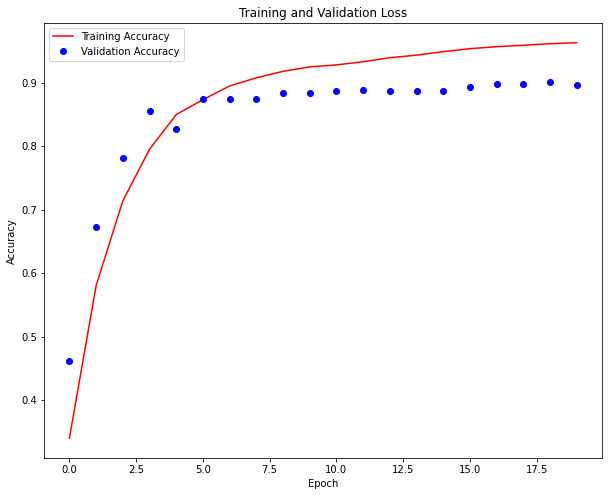

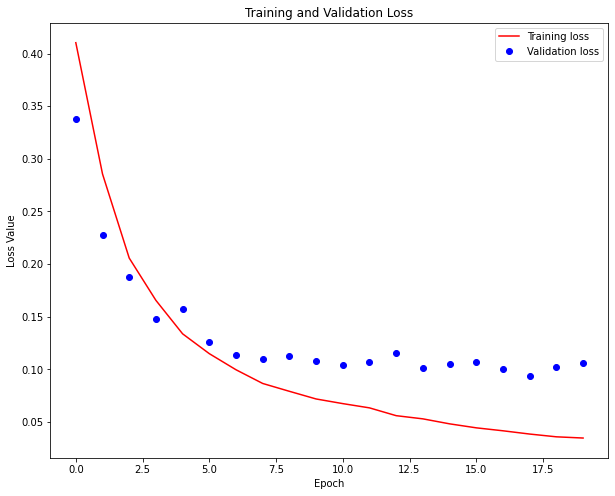

In [ ]:
loss = history.history['loss']
val_accuracy= history.history['val_accuracy']
val_loss = history.history['val_loss']
accuracy= history.history['accuracy']


epochs = range(20)

plt.figure(figsize=(10,8))
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# **Model 3 - Bidirectional**

In [ ]:
embedding_dim = 32 #number of dimensions for embedding layer

In [ ]:
from tensorflow.keras import layers
from keras.models import Sequential
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
#from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout

model = keras.Sequential(
    [
          layers.Embedding(uniqueWords,embedding_dim,input_length=maxLength),
          layers.Dropout(0.5),
          layers.Bidirectional(layers.LSTM(80,return_sequences=True)),
          layers.Bidirectional(layers.LSTM(160)),
          layers.Dense(6,activation='softmax')
    ]
)

print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 20, 32)            542304    
_________________________________________________________________
dropout_23 (Dropout)         (None, 20, 32)            0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 20, 160)           72320     
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 320)               410880    
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 1926      
Total params: 1,027,430
Trainable params: 1,027,430
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_padded,train_labels, epochs=20, validation_data=(val_padded, val_labels))

Epoch 1/20
500/500 [==============================] - 70s 127ms/step - loss: 0.4046 - accuracy: 0.3836 - val_loss: 0.2000 - val_accuracy: 0.7085
Epoch 2/20
500/500 [==============================] - 62s 124ms/step - loss: 0.1853 - accuracy: 0.7419 - val_loss: 0.1328 - val_accuracy: 0.8505
Epoch 3/20
500/500 [==============================] - 63s 125ms/step - loss: 0.1076 - accuracy: 0.8773 - val_loss: 0.0964 - val_accuracy: 0.8955
Epoch 4/20
500/500 [==============================] - 63s 125ms/step - loss: 0.0795 - accuracy: 0.9126 - val_loss: 0.0892 - val_accuracy: 0.8975
Epoch 5/20
500/500 [==============================] - 63s 125ms/step - loss: 0.0616 - accuracy: 0.9269 - val_loss: 0.0837 - val_accuracy: 0.9040
Epoch 6/20
500/500 [==============================] - 63s 125ms/step - loss: 0.0510 - accuracy: 0.9432 - val_loss: 0.0823 - val_accuracy: 0.9090
Epoch 7/20
500/500 [==============================] - 62s 124ms/step - loss: 0.0433 - accuracy: 0.9530 - val_loss: 0.0783 - val_ac

In [ ]:
model.evaluate(test_padded,test_labels)

63/63 [==============================] - 3s 40ms/step - loss: 0.0970 - accuracy: 0.9155


[0.09704176336526871, 0.9154999852180481]

In [ ]:
checkpoint_path = '/content/drive/My Drive/NLP_Final/weight_1.ckpt'
model_path = '/content/drive/My Drive/NLP_Final/Model_1'
model.save_weights(checkpoint_path.format(epoch=0))
model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/NLP_Final/Model_1/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/NLP_Final/Model_1/assets


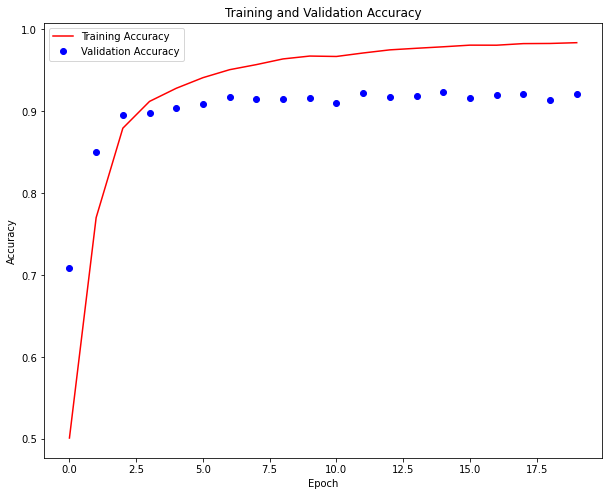

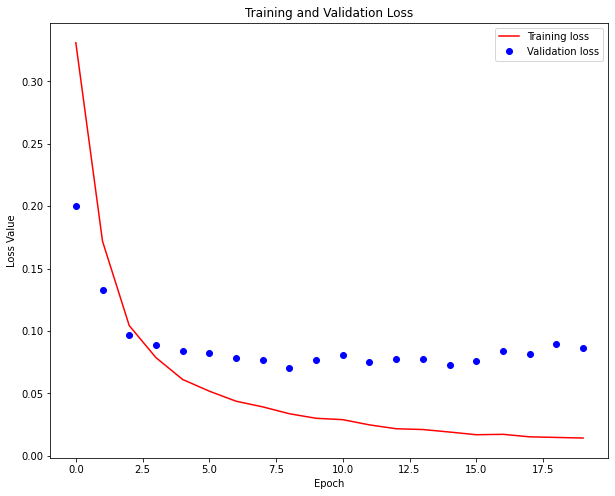

In [ ]:
loss = history.history['loss']
val_accuracy= history.history['val_accuracy']
val_loss = history.history['val_loss']
accuracy= history.history['accuracy']


epochs = range(20)

plt.figure(figsize=(10,8))
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [ ]:
df_test[1]= df_test[1].replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
test_labels = to_categorical(df_test[1].values)
test_sentences = df_test[0].to_numpy()
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=maxLength, padding="post", truncating="post")
model.evaluate(test_padded,test_labels)

63/63 [==============================] - 2s 35ms/step - loss: 0.0807 - accuracy: 0.9210


[0.08074072003364563, 0.9210000038146973]

In [ ]:
!pip install scikit-plot

In [ ]:
from sklearn.metrics import classification_report
import scikitplot
from scikitplot.metrics import plot_confusion_matrix

In [ ]:
predictions = model.predict_classes(test_padded)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
predictions

array([3, 3, 3, ..., 0, 0, 4])

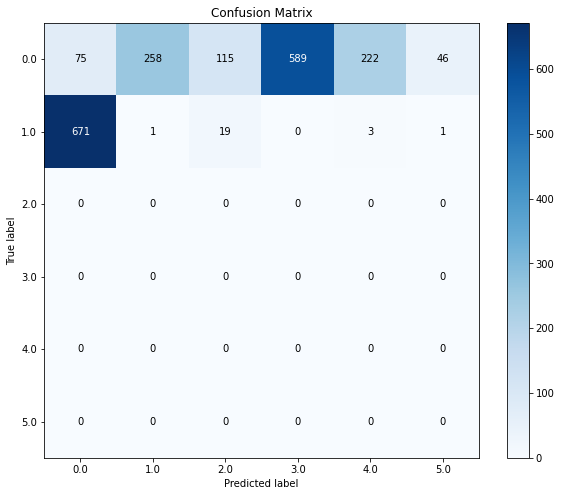

In [ ]:
plot_confusion_matrix(test_labels[:,0],predictions,figsize=(10,8))

In [ ]:
print(test_labels[:,0].shape, predictions.shape)


(2000,) (2000,)


In [ ]:
print(classification_report(test_labels[:,0],predictions))

              precision    recall  f1-score   support

         0.0       0.10      0.06      0.07      1305
         1.0       0.00      0.00      0.00       695
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0

    accuracy                           0.04      2000
   macro avg       0.02      0.01      0.01      2000
weighted avg       0.07      0.04      0.05      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
